# Collection of Visualizations for Streamlit

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

<hr style="border: 3px solid blue"> 

### Visualizations for Car Accident Claims by State

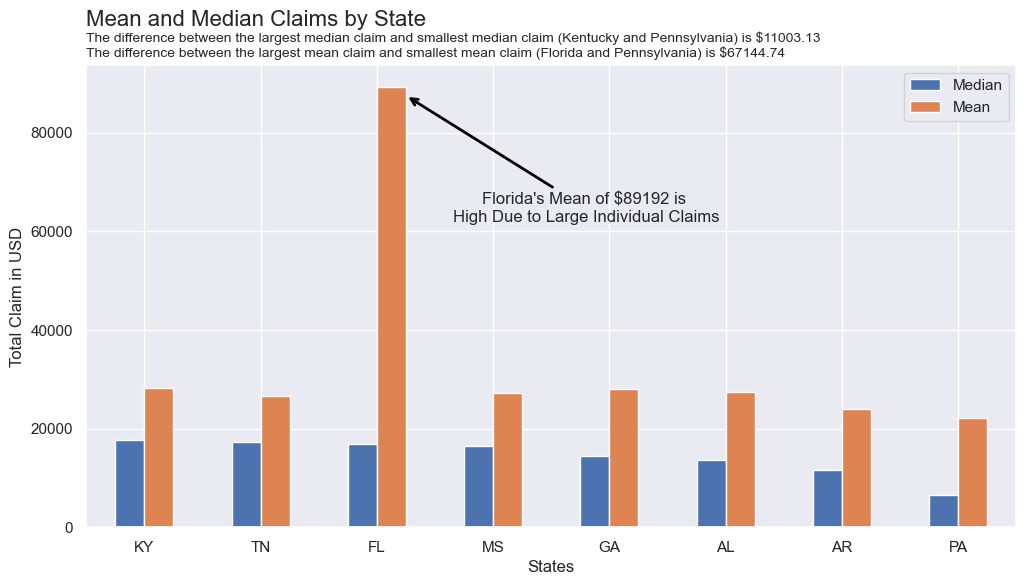

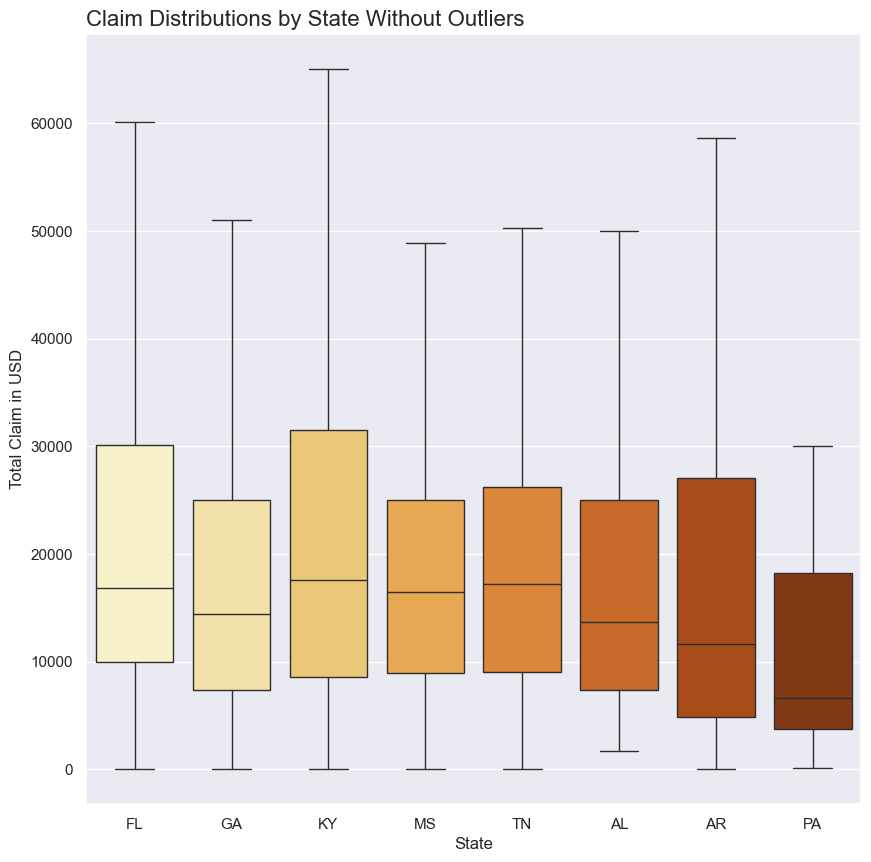

In [36]:
# Read in the data
data = pd.read_csv('../../../data/Preprocessed_datasets/sample_data_before_preprocessing.csv')

# Code from dagshub notebook used to arrive at the same number of rows as we have in our modeling set

# Get the claim amount as it is final target variable
data['claim_amount'] = np.where(data['total_bills']<=data['total_coverage'],data['total_bills'],data['total_coverage'])
# total_bills
data['total_bills'] = np.where(data['total_bills'].isnull(),data['claim_amount'],data['total_bills'])
# drop null value rows from claim amount
data = data.dropna(subset=['claim_amount'])
# drop rows with claim amount '0'
data = data[~(data['claim_amount']==0)]
# drop rows with -ve age
data = data[~(data['age']<0)]

# Consolidating for capitalization
data["state"] = data["state"].str.upper()

# Isolating states with fewer than 45 rows of data
small_obs = data["state"].value_counts()[data["state"].value_counts() < 45].index

# Binning small-observation states
data.loc[data["state"].isin(small_obs), "state"] = "Other"


# -------------------- Plots --------------------------------

# -------------------State Plots ----------------------------

sns.set()
# Plot the state-by-state breakdown of Means and Medians
grouped = data.groupby("state")["claim_amount"].agg(Lower_Bound=lambda x: x.quantile(0.25),
                                          Median="median",
                                          Upper_Bound=lambda x: x.quantile(0.75),
                                          Mean= "mean").round(2)
grouped.sort_values(by="Median", ascending=False)


# Figure Creation
fig, ax = plt.subplots(figsize=(12,6))

# Plotting Named States Only (meaning 45+ rows of data) by Median from highest median to lowest, change as needed
grouped[["Median", "Mean"]].drop("Other").sort_values(by="Median", ascending=False).plot(kind = "bar", ax=ax, rot=0)

# Labels and Format
ax.legend(["Median", "Mean"])
ax.set_ylabel("Total Claim in USD")
ax.set_xlabel("States")

# Title
fig.suptitle("Mean and Median Claims by State", y=.9725, x=0.125, ha="left", fontsize=16)
# ax.set_title("Mean and Median Claims by State Sorted by Median Claim", fontsize=16, loc="left") 
ax.set_title("The difference between the largest median claim and smallest median claim (Kentucky and Pennsylvania) is $11003.13 \nThe difference between the largest mean claim and smallest mean claim (Florida and Pennsylvania) is $67144.74", \
             fontsize=10, loc="left")

# Annotation
ax.annotate(xy=(2.25,87500), xytext=(3.8, 62000), text="Florida's Mean of $89192 is \nHigh Due to Large Individual Claims",
           arrowprops={"arrowstyle":"->", "linewidth":2, "color":"black"}, ha="center")

plt.show()

# Boxplot for State Data
pal = sns.set_palette("YlOrBr", n_colors=8)
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(data=data.query("state != 'Other'"), x="state", y="claim_amount", ax=ax, showfliers=False, hue="state", palette=pal)
ax.set_title("Claim Distributions by State Without Outliers", loc="left", fontsize=16)
ax.set_ylabel("Total Claim in USD")
ax.set_xlabel("State")
plt.show();

<hr style ="border: 3px solid blue">

# Gender Plots

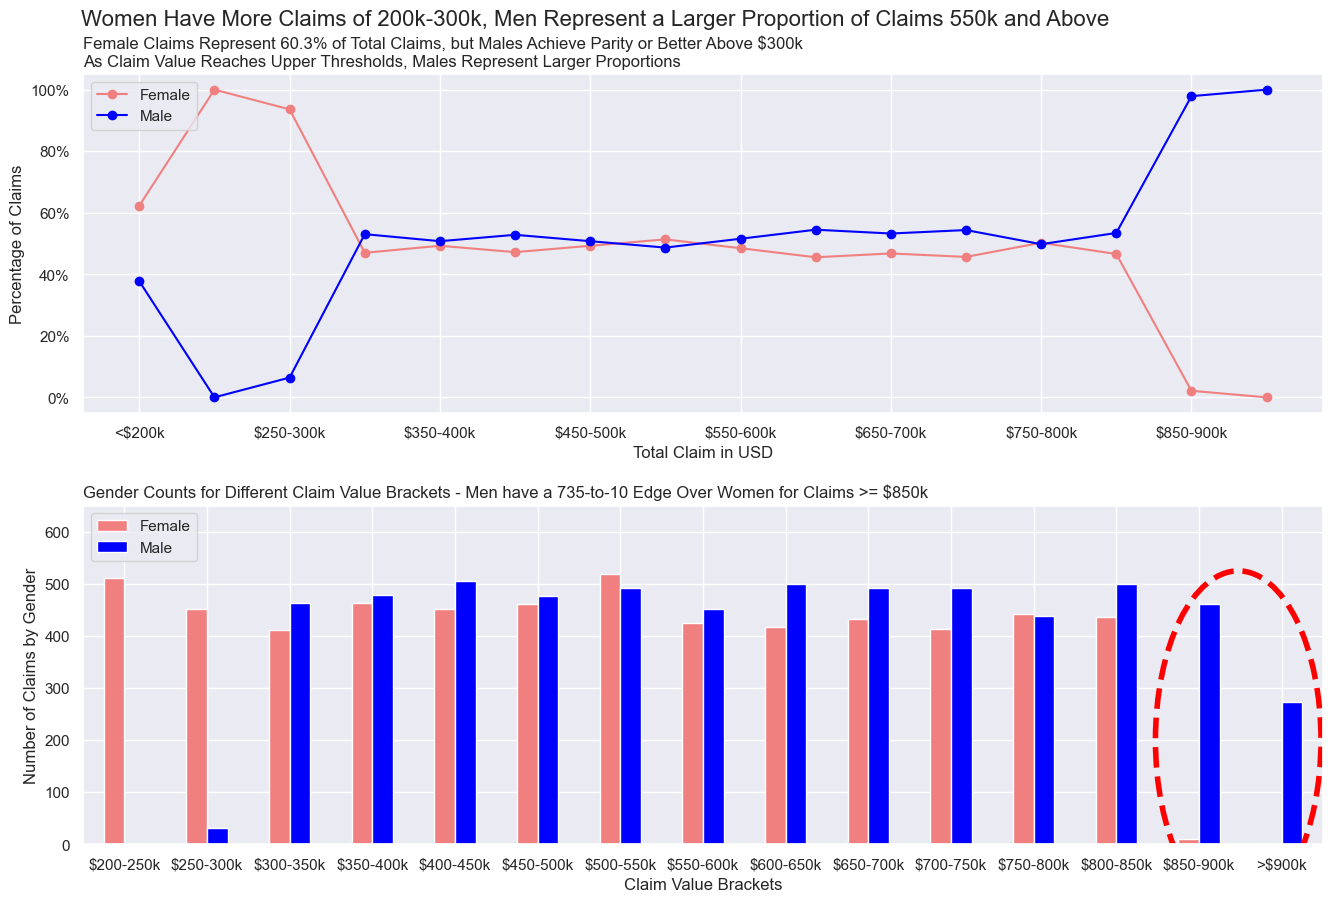

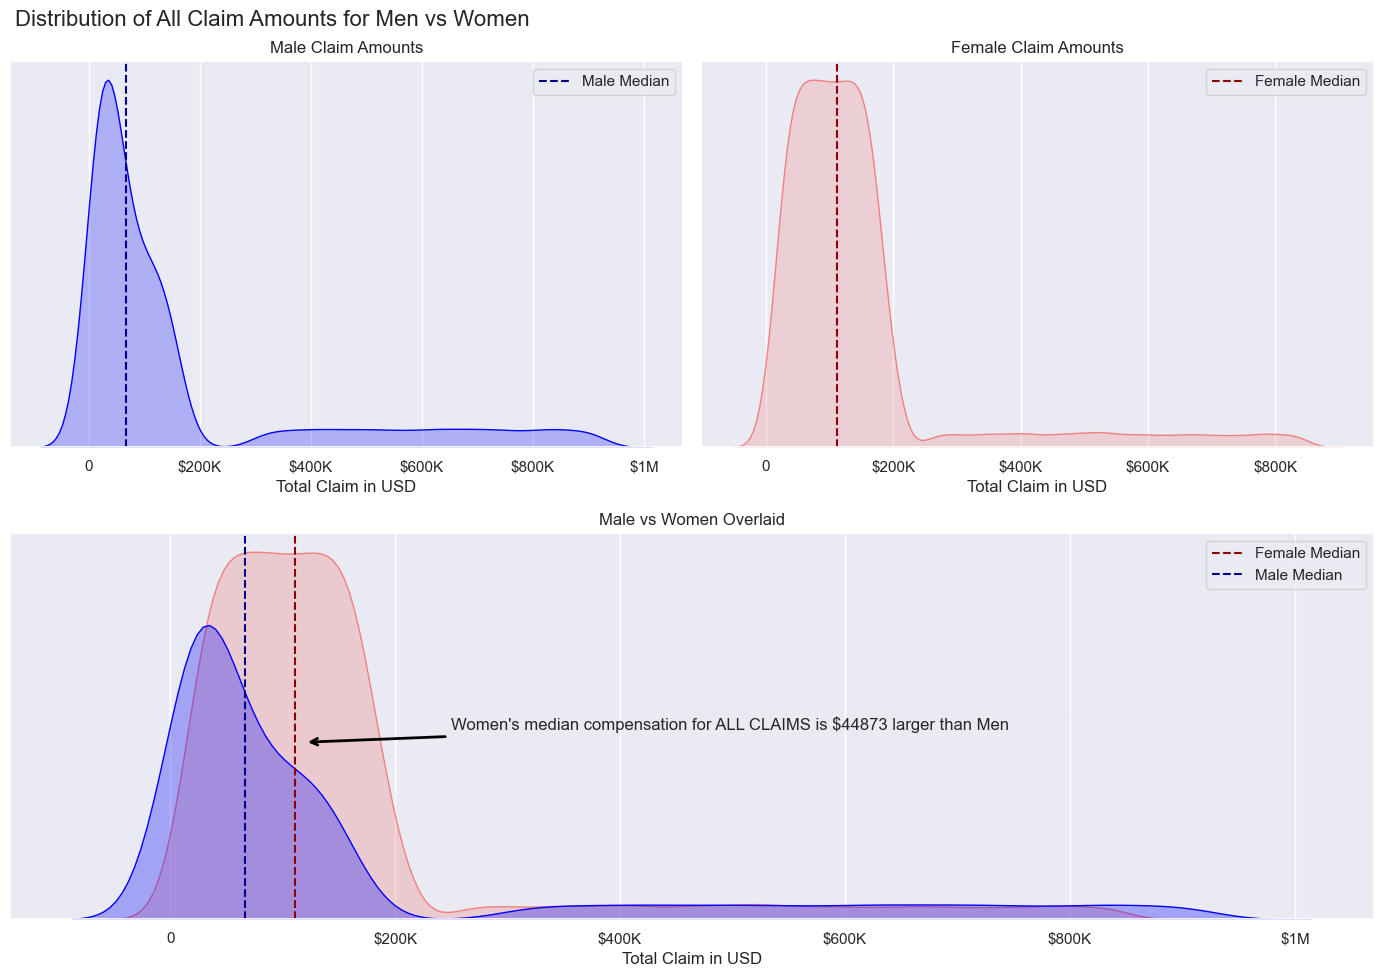

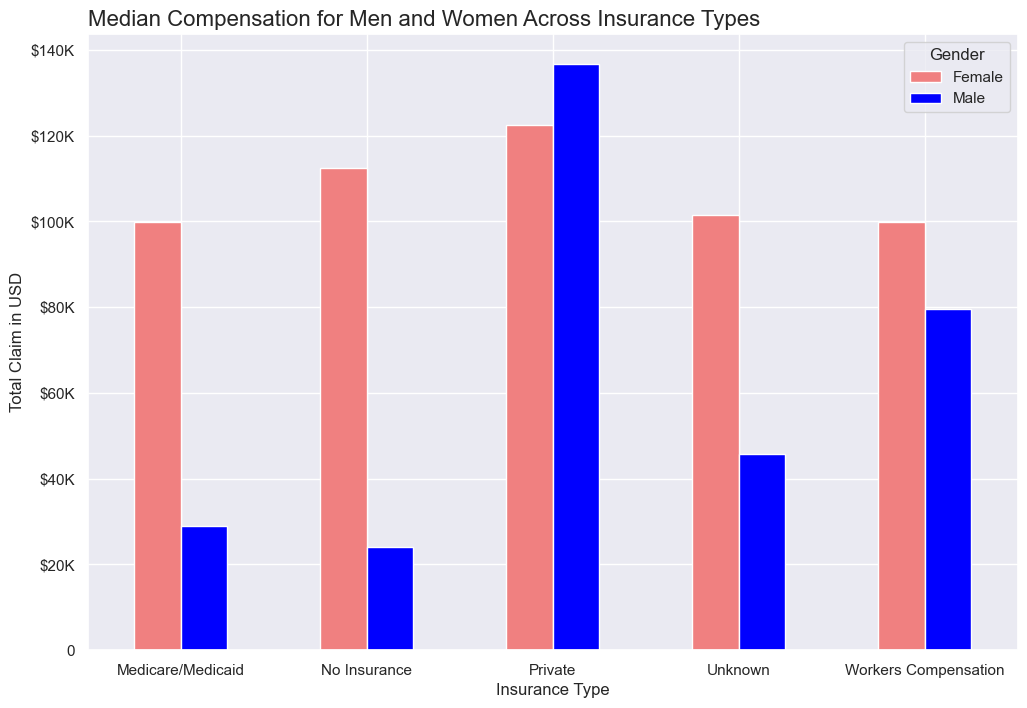

In [42]:
# Gender Data
df = pd.read_csv("../../../data/Preprocessed_datasets/Kaggle_medical_practice_20.csv", index_col=0)

# Using pd.cut() to create claim brackets

bins = [-np.inf, 200_000, 250_000, 300_000, 350_000, 400_000, 450_000, 500_000,
                                       550_000, 600_000, 650_000, 700_000, 750_000, 800_000, 850_000, 900_000, np.inf]
len(bins)

labels = ["<$200k", "$200-250k", "$250-300k", "$300-350k", "$350-400k", "$400-450k", "$450-500k", "$500-550k", "$550-600k",
          "$600-650k", "$650-700k", "$700-750k", "$750-800k", "$800-850k", "$850-900k", ">$900k"]

len(labels)

# Create New Feature for Claim Brackets
df["claim_category"] = pd.cut(df["total_claim_amount"], bins=bins, labels=labels)

# ---------------------- GENDER PLOTS ----------------------------

# First Plot
sns.set()
fig, ax = plt.subplots(nrows=2, figsize=(16, 10), gridspec_kw={"hspace":.275})

# Plotting Gender by the Claim Brackets Created Above
df.groupby("claim_category")["gender"].value_counts(normalize=True).multiply(100).unstack().plot(kind="line", marker="o",
                                                                                                ax=ax[0], color=["lightcoral", "blue"]);
# Labels for ax[0]
ax[0].set_ylabel("Percentage of Claims")
ax[0].set_xlabel("Total Claim in USD")
ax[0].set_yticks(np.linspace(0, 100, 6), labels=[str(round(i))+'%' for i in np.linspace(0, 100, 6)])

# ax[0] legend and title
ax[0].legend(loc="upper left")
ax[0].set_title("""Female Claims Represent 60.3% of Total Claims, but Males Achieve Parity or Better Above $300k 
As Claim Value Reaches Upper Thresholds, Males Represent Larger Proportions""", loc="left", fontsize=12)

# 2nd plot
df.groupby("claim_category")["gender"].value_counts().drop("<$200k").unstack().plot(kind="bar", ax=ax[1], rot=0, color=["lightcoral", "blue"])

# ax[1] labels
ax[1].set_ylabel("Number of Claims by Gender")
ax[1].set_xlabel("Claim Value Brackets")

# Expand y axis range to accommodate annotations
ax[1].set_ylim(0, 650)

# ax[1] titles and legend
ax[1].set_title("Gender Counts for Different Claim Value Brackets - Men have a 735-to-10 Edge Over Women for Claims >= $850k", loc="left", fontsize=12)
ax[1].legend(loc="upper left")
fig.suptitle("Women Have More Claims of 200k-300k, Men Represent a Larger Proportion of Claims 550k and Above", 
             fontsize=16, y=.945, x= 0.445)

# CREATING A CIRCLED PART OF ax[1]
# Coordinates for the bars to circle
bar_labels = ax[1].get_xticklabels()
rightmost_bars = bar_labels[-2:]

# Calculate center and size for the ellipse
center_x = (rightmost_bars[0].get_position()[0] + rightmost_bars[1].get_position()[0]) / 2 -.025
center_y = 200  # Adjust as necessary to vertically center the ellipse around the bars
width = rightmost_bars[1].get_position()[0] - rightmost_bars[0].get_position()[0] + 1  # Width to cover both bars
height = 650  # Adjust as necessary to fit around the bars

# Add the ellipse to the plot
ellipse = Ellipse((center_x, center_y), width=width+.0025, height=height, edgecolor='red', facecolor='none', linewidth=4, linestyle="--")
ax[1].add_patch(ellipse)

# Show the plot
plt.show()

# --------------2nd plot---------------------

# Create a GridSpec with 2 rows and 2 columns
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

# Create First ax1, First row, first column
ax1 = fig.add_subplot(gs[0, 0])

# Density Plot
sns.kdeplot(data=df.query("gender == 'Male'"), x="total_claim_amount", fill=True, ax=ax1, color="blue")

# Make y-axis Invisible 
ax1.get_yaxis().set_visible(False)

# Annotations and Titles for ax1
ax1.axvline(df.query("gender == 'Male'")["total_claim_amount"].median(), label="Male Median", linestyle="--", color="darkblue")
ax1.set_xticks([0, 2e5, 4e5, 6e5, 8e5, 1e6], labels=["0", "$200K", "$400K", "$600K", "$800K", "$1M"])
ax1.legend()
ax1.set_xlabel("Total Claim in USD")
ax1.set_title('Male Claim Amounts')

# Create second plot ax2, First row, second column
ax2 = fig.add_subplot(gs[0, 1])

# Density Plot
sns.kdeplot(data=df.query("gender == 'Female'"), x="total_claim_amount", ax=ax2, fill=True, color="lightcoral")

# Make y-axis Invisible
ax2.get_yaxis().set_visible(False)

# Annotations and Titles for ax2
ax2.axvline(df.query("gender == 'Female'")["total_claim_amount"].median(), label="Female Median", linestyle="--", color="darkred")
ax2.set_xticks([0, 2e5, 4e5, 6e5, 8e5], labels=["0", "$200K", "$400K", "$600K", "$800K"])
ax2.legend()
ax2.set_xlabel("Total Claim in USD")
ax2.set_title('Female Claim Amounts')

# Third Plot Second row (spans both columns)
ax3 = fig.add_subplot(gs[1, :])

# Density Plot of Both Gender Distributions Overlaid
sns.kdeplot(data=df, x="total_claim_amount", hue="gender", fill=True, alpha= .3, ax=ax3, palette=["blue", "lightcoral"])

# Make y-axis Invisible
ax3.get_yaxis().set_visible(False)

# Labels and Annotations
ax3.set_xlabel("Total Claim in USD")
ax3.axvline(df.query("gender == 'Female'")["total_claim_amount"].median(), label="Female Median", linestyle="--", color="darkred")
ax3.axvline(df.query("gender == 'Male'")["total_claim_amount"].median(), label="Male Median", linestyle="--", color="darkblue")
ax3.annotate(xytext=(.25e6, 1.6e-6), xy=(.12e6,1.5e-6), text="Women's median compensation for ALL CLAIMS is $44873 larger than Men",
            arrowprops={"arrowstyle":"->", "linewidth":2, "color":"black"})
ax3.set_xticks([0, 2e5, 4e5, 6e5, 8e5, 1e6], labels=["0", "$200K", "$400K", "$600K", "$800K", "$1M"])
ax3.legend()
ax3.set_title('Male vs Women Overlaid')

# Super-Title
fig.suptitle(f"Distribution of All Claim Amounts for Men vs Women", fontsize=16, x=.2, y=.975)

# Adjust the layout to prevent overlapping titles and labels
plt.tight_layout()
plt.show()

# ----------- 3rd Plot of Median Claim Size by Gender Across Different Insurance Types ----------------

# Create Figure
fig, ax = plt.subplots(figsize=(12,8))

# Use Pandas Built-In Matplotlib Plotting Ability
df.groupby(["insurance", "gender"])["total_claim_amount"].median().unstack().plot(kind="bar", ax=ax, rot=0, color=["lightcoral", "blue"])

# Titles and Labels
ax.set_title("Median Compensation for Men and Women Across Insurance Types", loc="left", fontsize=16)
ax.set_xlabel("Insurance Type")
ax.set_ylabel("Total Claim in USD")

# Adjusting Legend and y-ticklabels
ax.legend(title="Gender")
ax.set_yticks(np.linspace(0, 140_000, 8), labels=["0", "$20K","$40K","$60K","$80K","$100K", "$120K", "$140K"])

# Show Plot
plt.show();

#### Post Accident Actions by Mariam

In [1]:
import pandas as pd
import plotly.graph_objects as go
import streamlit as st

# Load and preprocess the datasets
@st.cache_data
def load_data():
    df = pd.read_csv('/Users/mukaminjeru/Phoenix/data/Preprocessed_datasets/sample_data_formatted.csv')
    df['total_bills'] = pd.to_numeric(df['total_bills'], errors='coerce')
    df['total_coverage'] = pd.to_numeric(df['total_coverage'], errors='coerce')
    df['total_claim_amount'] = df[['total_bills', 'total_coverage']].min(axis=1)
    df['airbag_deployed'] = df['airbag_deployed'].fillna('No')
    df['called_911'] = df['called_911'].fillna('Unknown')
    df['called_911'] = df['called_911'].apply(lambda x: 'Yes' if x == 'Yes' else ('No' if x == 'No' else 'Unknown'))
    df = df.dropna(subset=['total_claim_amount'])
    Q1 = df['total_claim_amount'].quantile(0.25)
    Q3 = df['total_claim_amount'].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df['total_claim_amount'] < (Q1 - 1.5 * IQR)) | (df['total_claim_amount'] > (Q3 + 1.5 * IQR)))]
    return df

@st.cache_data
def load_data2():
    df2 = pd.read_csv('/Users/mukaminjeru/Phoenix/data/Preprocessed_datasets/Kaggle_medical_practice_20.csv')
    df2['total_claim_amount'] = pd.to_numeric(df2['total_claim_amount'], errors='coerce')
    df2 = df2.dropna(subset=['total_claim_amount'])
    Q1 = df2['total_claim_amount'].quantile(0.25)
    Q3 = df2['total_claim_amount'].quantile(0.75)
    IQR = Q3 - Q1
    df2 = df2[~((df2['total_claim_amount'] < (Q1 - 1.5 * IQR)) | (df2['total_claim_amount'] > (Q3 + 1.5 * IQR)))]
    return df2

df = load_data()
df2 = load_data2()

# Calculate mean and median for airbag deployment and 911 call
mean_median_airbag = df.groupby('airbag_deployed')['total_claim_amount'].agg(['mean', 'median']).reset_index()
mean_median_911 = df.groupby('called_911')['total_claim_amount'].agg(['mean', 'median']).reset_index()
mean_median_attorney = df2.groupby('private_attorney')['total_claim_amount'].agg(['mean', 'median']).reset_index()

# Create Streamlit app
st.title('Insurance Claims Analysis')

# Airbag deployment
st.subheader('Mean and Median Total Claim Amount by Airbag Deployment')
fig_airbag = go.Figure()
fig_airbag.add_trace(go.Bar(
    x=mean_median_airbag['airbag_deployed'],
    y=mean_median_airbag['mean'],
    name='Mean',
    marker_color='blue'
))
fig_airbag.add_trace(go.Bar(
    x=mean_median_airbag['airbag_deployed'],
    y=mean_median_airbag['median'],
    name='Median',
    marker_color='lightblue'
))
fig_airbag.update_layout(
    barmode='group',
    xaxis_title='Airbag Deployed',
    yaxis_title='Total Claim Amount',
    legend_title='Statistics'
)
st.plotly_chart(fig_airbag)

# 911 call
st.subheader('Mean and Median Total Claim Amount by 911 Call')
fig_911 = go.Figure()
fig_911.add_trace(go.Bar(
    x=mean_median_911['called_911'],
    y=mean_median_911['mean'],
    name='Mean',
    marker_color='green'
))
fig_911.add_trace(go.Bar(
    x=mean_median_911['called_911'],
    y=mean_median_911['median'],
    name='Median',
    marker_color='lightgreen'
))
fig_911.update_layout(
    barmode='group',
    xaxis_title='911 Called',
    yaxis_title='Total Claim Amount',
    legend_title='Statistics'
)
st.plotly_chart(fig_911)

# Private attorney
st.subheader('Mean and Median Total Claim Amount by Private Attorney')
fig_attorney = go.Figure()
fig_attorney.add_trace(go.Bar(
    x=mean_median_attorney['private_attorney'].map({0: 'No', 1: 'Yes'}),
    y=mean_median_attorney['mean'],
    name='Mean',
    marker_color='orange'
))
fig_attorney.add_trace(go.Bar(
    x=mean_median_attorney['private_attorney'].map({0: 'No', 1: 'Yes'}),
    y=mean_median_attorney['median'],
    name='Median',
    marker_color='darkorange'
))
fig_attorney.update_layout(
    barmode='group',
    xaxis_title='Private Attorney',
    yaxis_title='Total Claim Amount',
    legend_title='Statistics'
)
st.plotly_chart(fig_attorney)


2024-06-17 08:14:31.813 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-06-17 08:14:31.816 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-06-17 08:14:32.023 
  command:

    streamlit run /Users/mukaminjeru/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-06-17 08:14:32.024 No runtime found, using MemoryCacheStorageManager
2024-06-17 08:14:32.514 No runtime found, using MemoryCacheStorageManager


DeltaGenerator()